In [1]:
from sympy import symbols, cos, sin, diff, Function, simplify

# Define symbols
theta = symbols('theta')
k, e, h, GM, sigma = symbols('k e h GM sigma')

# Define r(theta)
r = (h ** 2 / GM) / (1 + e * cos(theta *sigma))

# Calculate dr/dtheta
dr_dtheta = diff(r, theta)

# Define omega(theta) = dtheta/dt
omega = h / r**2

# Calculate d^2r/dtheta^2
d2r_dtheta2 = diff(dr_dtheta, theta)

# Calculate domega/dtheta
domega_dtheta = diff(omega, theta)

dr_dt = diff(r,theta)*omega
# Calculate d^2r/dt^2 using chain rule
d2r_dt2 = simplify(d2r_dtheta2 * omega**2 + dr_dtheta * domega_dtheta * omega)

# Calculate d^2theta/dt^2
# Differentiate omega(theta)
d2theta_dt2 = simplify(domega_dtheta * omega)

# Display the results

eq1 = f"r= {r}".replace("cos", "np.cos").replace("sin", "np.sin")
eq2 = f"theta_dot= h/r**2".replace("cos", "np.cos").replace("sin", "np.sin")
eq3 = f"dr_dtheta = {dr_dtheta}".replace("cos", "np.cos").replace("sin", "np.sin")
eq4 = f"d2r_dtheta2 = {d2r_dtheta2}".replace("cos", "np.cos").replace("sin", "np.sin")
eq5 = f"domega_dtheta = {domega_dtheta}".replace("cos", "np.cos").replace("sin", "np.sin")
eq6 = f"d2r_dt2 = {d2r_dt2}".replace("cos", "np.cos").replace("sin", "np.sin")
eq7 = f"d2theta_dt2 = {d2theta_dt2}".replace("cos", "np.cos").replace("sin", "np.sin")
eq8 = f"dr_dt = {dr_dt}".replace("cos", "np.cos").replace("sin", "np.sin")

print(eq1)
print(eq2)
# print(eq3)
# print(eq4)
# print(eq5)
print(eq6)
# print(eq7)
print(eq8)


r= h**2/(GM*(e*np.cos(sigma*theta) + 1))
theta_dot= h/r**2
d2r_dt2 = GM**3*e*sigma**2*(e*np.cos(sigma*theta) + 1)**2*np.cos(sigma*theta)/h**4
dr_dt = GM*e*sigma*np.sin(sigma*theta)/h


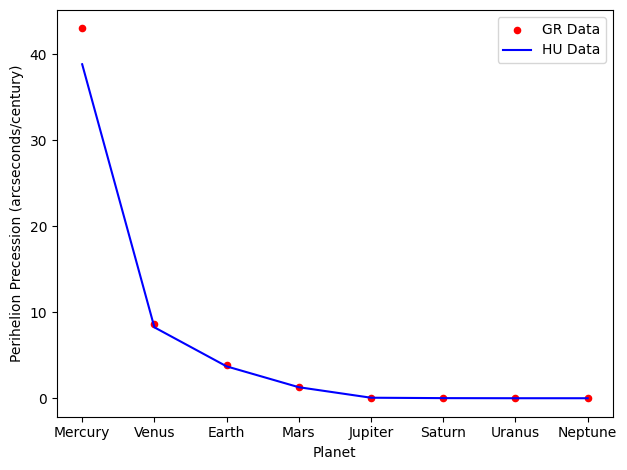

In [2]:
# import numpy as np
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy import constants as cc, units as uu
from scipy.optimize import curve_fit

# Constants
G = cc.G  # gravitational constant in m^3 kg^-1 s^-2
M = cc.M_sun  # mass of the Sun in kg
c = cc.c.si.value  # speed of light in m/s
GM = (G*M).si.value # gravitational parameter for the Sun in m^3/s^2

def r_derivatives(theta, h, e, GM, x):
    sigma = x[0]
    # Expression for r, r_dot, and r_double_dot
    r= h**2/(GM*(e*np.cos(sigma*theta) + 1))
    theta_dot= h/r**2
    dr_dtheta = e*h**2*sigma*np.sin(sigma*theta)/(GM*(e*np.cos(sigma*theta) + 1)**2)
    d2r_dt2 = GM**3*e*sigma**2*(e*np.cos(sigma*theta) + 1)**2*np.cos(sigma*theta)/h**4
    dr_dt = GM*e*sigma*np.sin(sigma*theta)/h
    return r, dr_dt, d2r_dt2, theta_dot


def error_functionHU(x, h, e, GM):
    sigma = x[0]
    def integrand(theta):
        r, r_dot, r_double_dot,theta_dot = r_derivatives(theta, h, e, GM, x)
        a_theoretical = HU_Accel(GM, r, r_dot, theta_dot)
        a_numerical = r_double_dot - r * theta_dot ** 2  # Assuming r_double_dot is defined 
                                                         # to calculate \ddot{r}
        return (a_theoretical - a_numerical)**2

    sigma = x[0]
    integral_error, _ = quad(integrand, 0, 2*np.pi/sigma, epsabs=1e-16, epsrel=1e-16)
    return 100*integral_error


def HU_Accel(GM, r, r_dot, theta_dot):
    v1 = np.sqrt(r_dot**2 + r**2 * theta_dot**2)
    gamma_v1 = 1 / np.sqrt(1 - v1**2 / c**2)
    P2_hat = np.sqrt(1 + v1**2/c**2 - 2*r_dot/c)
    a_theoretical = -GM /r**2*(P2_hat * gamma_v1 **(-3)/( (gamma_v1 - 1)*(r_dot/v1)**2 +1 ) )
    return a_theoretical

def calculatePrecession(errorf, a, e, T):
    h = np.sqrt(GM * a * (1 - e ** 2))
    # Initial guess for sigma
    initial_x = [0.95]
    result = minimize(errorf, initial_x, method='Nelder-Mead', args=(h,e,GM) ,tol=1E-15)
    optimized_sigma = result.x  # The optimized value for sigma
    if( not result.success):
        print(result)
    days_in_century = 36525  # Number of days in a century

    # Calculation of precession per orbit in radians
    delta_phi_per_orbit = 2 * np.pi * (optimized_sigma-1)
    delta_phi_per_orbit_GR = (6 * np.pi * GM) / (a * (1 - e ** 2) * c ** 2)

    # Calculate the number of orbits per century
    orbits_per_century = days_in_century / T

    # Precession per century in arcseconds
    delta_phi_per_century = delta_phi_per_orbit * orbits_per_century * (
                180 / np.pi) * 3600  # Convert radians to arcseconds
    delta_phi_per_century_GR = delta_phi_per_orbit_GR * orbits_per_century * (
                180 / np.pi) * 3600  # Convert radians to arcseconds


    return delta_phi_per_century[0], delta_phi_per_century_GR


# https://nssdc.gsfc.nasa.gov/planetary/factsheet/mercuryfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/venusfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/marsfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/jupiterfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/saturnfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/uranusfact.html
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/neptunefact.html

# https://farside.ph.utexas.edu/teaching/336k/Newton/node115.html#e13.126

a_ = [57.909E9, 108.210E9, 149.598E9, 227.956E9, 778.479E9, 1432.041E9,  2867.043E9,   4514.953E9]
e_ = [0.2056,   0.0068,    0.0167,    0.0935,    0.0487,    0.0520,       0.0469,      0.0097]
T_ = [87.969,   224.701,   365.256,   686.980,   4332.589, 10759.22,    30685.4,      60189]


Planet = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]

df = pd.DataFrame(index=Planet, columns=['Planet', 'delta_HU', "delta_GR"])
df["Planet"] = Planet
for i, (a, e, T, name) in enumerate(zip(a_, e_, T_, Planet)):
    df.loc[name, ['delta_HU', "delta_GR"]] = calculatePrecession(error_functionHU, a, e, T)


ax = df.plot.scatter(x="Planet", y="delta_GR", label='GR Data', color='red')
df.plot(x="Planet", y="delta_HU", label='HU Data', color='blue', ax=ax)

ax.set_ylabel('Perihelion Precession (arcseconds/century)')
ax.legend()
# ax.set_yscale("log")

plt.tight_layout()
plt.savefig("./Drawing_For_Publications/HU_GR_Comparison.png")
plt.show()

In [3]:
# Observed precession rates (arcseconds/year)
delta_Psi_obs = [5.75, 2.04, 11.45, 16.28, 6.55, 19.50, 3.34, 0.36]

# Theoretical precession rates (arcseconds/year)
delta_Psi_th = [5.50, 10.75, 11.87, 17.60, 7.42, 18.36, 2.72, 0.65]

# Convert to precession rates per century
df [ "delta_Psi_obs_century" ] = [rate * 100 for rate in delta_Psi_obs]
df [ "delta_Psi_th_century" ] = [rate * 100 for rate in delta_Psi_th]


df["Planet"] = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
df["delta_obs"] = [43.11, 8.40, 3.84, 1.35, 0.06, 0.013, 0.0023, 0.0008]  # Observed values
df["error_obs"] = [0.21, 0.15, 0.11, 0.05, 0.02, 0.001, 0.0002, 0.0001]   # Error bars for observed values
df

,Planet,delta_HU,delta_GR,delta_Psi_obs_century,delta_Psi_th_century,delta_obs,error_obs
Mercury,Mercury,38.823282,42.980208,575.0,550.0,43.1100,0.2100
Venus,Venus,8.243586,8.624509,204.0,1075.0,8.4000,0.1500
Earth,Earth,3.706014,3.838705,1145.0,1187.0,3.8400,0.1100
Mars,Mars,1.281627,1.350843,1628.0,1760.0,1.3500,0.0500
Jupiter,Jupiter,0.060075,0.062319,655.0,742.0,0.0600,0.0200
Saturn,Saturn,0.013267,0.013647,1950.0,1836.0,0.0130,0.0010
Uranus,Uranus,0.002195,0.002389,334.0,272.0,0.0023,0.0002
Neptune,Neptune,0.000802,0.000772,36.0,65.0,0.0008,0.0001


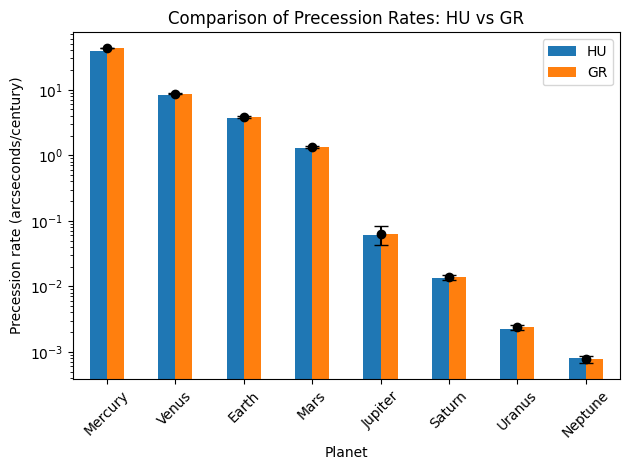

In [4]:
import matplotlib.pyplot as plt
import pandas as pd


df.set_index('Planet', inplace=True)

# Plot
fig, ax = plt.subplots()

# Plot delta_HU and delta_GR
df[['delta_HU', 'delta_GR']].plot(kind='bar', ax=ax)

# Add error bars for delta_GR
ax.errorbar(df.index, df['delta_GR'], yerr=df['error_obs'], fmt='o', color='black', capsize=5)

# Labels and title
ax.set_ylabel('Precession rate (arcseconds/century)')
ax.set_title('Comparison of Precession Rates: HU vs GR')
ax.legend(['HU', 'GR'])
ax.set_yscale("log")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


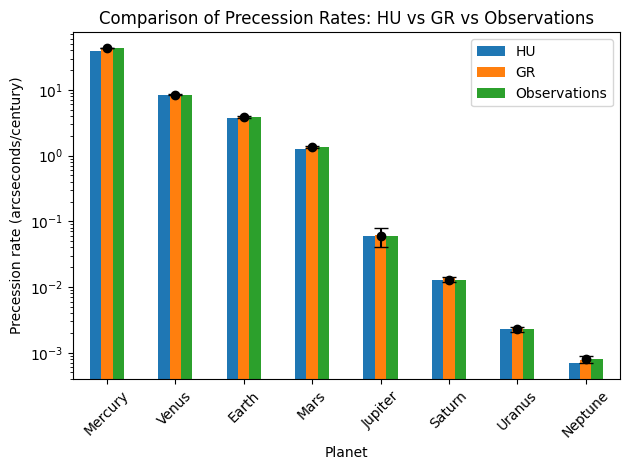

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the document and your calculations
data = {
    "Planet": ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"],
    "delta_HU": [38.589497, 8.274852, 3.694609, 1.277684, 0.059647, 0.013001, 0.002325, 0.000693],
    "delta_GR": [42.964879, 8.625333, 3.838716, 1.35111, 0.062313, 0.01364, 0.002386, 0.000775],
    "delta_obs": [43.11, 8.40, 3.84, 1.35, 0.06, 0.013, 0.0023, 0.0008],  # Observed values
    "error_obs": [0.21, 0.15, 0.11, 0.05, 0.02, 0.001, 0.0002, 0.0001]   # Error bars for observed values
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index('Planet', inplace=True)

# Plot
fig, ax = plt.subplots()

# Plot delta_HU, delta_GR, and delta_obs
df[['delta_HU', 'delta_GR', 'delta_obs']].plot(kind='bar', ax=ax)

# Add error bars for observations
ax.errorbar(df.index, df['delta_obs'], yerr=df['error_obs'], fmt='o', color='black', capsize=5)

# Labels and title
ax.set_ylabel('Precession rate (arcseconds/century)')
ax.set_title('Comparison of Precession Rates: HU vs GR vs Observations')
ax.legend(['HU', 'GR', 'Observations'])

plt.xticks(rotation=45)
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("./Drawing_For_Publications/HU_GR_Obs_Comparison.png")
plt.show()


In [6]:
import pandas as pd

# Data
a_ = [57.909E9, 108.210E9, 149.598E9, 227.956E9, 778.479E9, 1432.041E9, 2867.043E9, 4514.953E9]
e_ = [0.2056, 0.0068, 0.0167, 0.0935, 0.0487, 0.0520, 0.0469, 0.0097]
T_ = [87.969, 224.701, 365.256, 686.980, 4332.589, 10759.22, 30685.4, 60189]

# Observed precession rates (arcseconds/year)
delta_Psi_obs = [5.75, 2.04, 11.45, 16.28, 6.55, 19.50, 3.34, 0.36]

# Theoretical precession rates (arcseconds/year)
delta_Psi_th = [5.50, 10.75, 11.87, 17.60, 7.42, 18.36, 2.72, 0.65]

# Convert to precession rates per century
delta_Psi_obs_century = [rate * 100 for rate in delta_Psi_obs]
delta_Psi_th_century = [rate * 100 for rate in delta_Psi_th]

# Create DataFrame
df = pd.DataFrame({
    "planet": ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"],
    "semi_major_axis": a_,
    "eccentricity": e_,
    "period": T_,
    "delta_Psi_obs_year": delta_Psi_obs,
    "delta_Psi_obs_century": delta_Psi_obs_century,
    "delta_Psi_th_year": delta_Psi_th,
    "delta_Psi_th_century": delta_Psi_th_century
})

print(df)


    planet  semi_major_axis  eccentricity     period  delta_Psi_obs_year  \
0  Mercury     5.790900e+10        0.2056     87.969                5.75   
1    Venus     1.082100e+11        0.0068    224.701                2.04   
2    Earth     1.495980e+11        0.0167    365.256               11.45   
3     Mars     2.279560e+11        0.0935    686.980               16.28   
4  Jupiter     7.784790e+11        0.0487   4332.589                6.55   
5   Saturn     1.432041e+12        0.0520  10759.220               19.50   
6   Uranus     2.867043e+12        0.0469  30685.400                3.34   
7  Neptune     4.514953e+12        0.0097  60189.000                0.36   

   delta_Psi_obs_century  delta_Psi_th_year  delta_Psi_th_century  
0                  575.0               5.50                 550.0  
1                  204.0              10.75                1075.0  
2                 1145.0              11.87                1187.0  
3                 1628.0              17.60

In [7]:
import pandas as pd

# Data
a_ = [57.909E9, 108.210E9, 149.598E9, 227.956E9, 778.479E9, 1432.041E9, 2867.043E9, 4514.953E9]
e_ = [0.2056, 0.0068, 0.0167, 0.0935, 0.0487, 0.0520, 0.0469, 0.0097]
T_ = [87.969, 224.701, 365.256, 686.980, 4332.589, 10759.22, 30685.4, 60189]

# Observed precession rates (arcseconds/year)
delta_Psi_obs = [5.75, 2.04, 11.45, 16.28, 6.55, 19.50, 3.34, 0.36]

# Theoretical precession rates (arcseconds/year)
delta_Psi_th = [5.50, 10.75, 11.87, 17.60, 7.42, 18.36, 2.72, 0.65]

# Convert to precession rates per century
delta_Psi_obs_century = [rate * 100 for rate in delta_Psi_obs]
delta_Psi_th_century = [rate * 100 for rate in delta_Psi_th]

# Calculate relativistic contribution
delta_Psi_rel = [obs - th for obs, th in zip(delta_Psi_obs_century, delta_Psi_th_century)]

# Create DataFrame
df = pd.DataFrame({
    "planet": ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"],
    "semi_major_axis": a_,
    "eccentricity": e_,
    "period": T_,
    "delta_Psi_obs_year": delta_Psi_obs,
    "delta_Psi_obs_century": delta_Psi_obs_century,
    "delta_Psi_th_year": delta_Psi_th,
    "delta_Psi_th_century": delta_Psi_th_century,
    "delta_Psi_rel": delta_Psi_rel
})

print(df)


    planet  semi_major_axis  eccentricity     period  delta_Psi_obs_year  \
0  Mercury     5.790900e+10        0.2056     87.969                5.75   
1    Venus     1.082100e+11        0.0068    224.701                2.04   
2    Earth     1.495980e+11        0.0167    365.256               11.45   
3     Mars     2.279560e+11        0.0935    686.980               16.28   
4  Jupiter     7.784790e+11        0.0487   4332.589                6.55   
5   Saturn     1.432041e+12        0.0520  10759.220               19.50   
6   Uranus     2.867043e+12        0.0469  30685.400                3.34   
7  Neptune     4.514953e+12        0.0097  60189.000                0.36   

   delta_Psi_obs_century  delta_Psi_th_year  delta_Psi_th_century  \
0                  575.0               5.50                 550.0   
1                  204.0              10.75                1075.0   
2                 1145.0              11.87                1187.0   
3                 1628.0              1